# B2B Courier Charges Accuracy Analysis using Python

In today’s fast-paced e-commerce industry, fast and efficient order delivery is crucial to business success. To ensure seamless order fulfilment, businesses often partner with courier companies to ship their products to customers. However, managing the charges collected by these courier companies can be difficult, especially when dealing with a high volume of orders. It is one of the real-time problems B2B businesses experience when their estimated charges for the same invoice don’t match.

B2B courier charges accuracy analysis focuses on assessing the accuracy of fees charged by courier companies for the delivery of goods in B2B transactions. The aim is to ensure that companies are billed appropriately for the services provided by courier companies.

In [1]:
import pandas as pd

order_report = pd.read_csv('Order Report.csv')
sku_master = pd.read_csv('SKU Master.csv')
pincode_mapping = pd.read_csv('pincodes.csv')
courier_invoice = pd.read_csv('Invoice.csv')
courier_company_rates = pd.read_csv('Courier Company - Rates.csv')

print("Order Report:")
print(order_report.head())
print("\nSKU Master:")
print(sku_master.head())
print("\nPincode Mapping:")
print(pincode_mapping.head())
print("\nCourier Invoice:")
print(courier_invoice.head())
print("\nCourier Company rates:")
print(courier_company_rates.head())

Order Report:
   ExternOrderNo            SKU  Order Qty  Unnamed: 3  Unnamed: 4
0     2001827036  8904223818706        1.0         NaN         NaN
1     2001827036  8904223819093        1.0         NaN         NaN
2     2001827036  8904223819109        1.0         NaN         NaN
3     2001827036  8904223818430        1.0         NaN         NaN
4     2001827036  8904223819277        1.0         NaN         NaN

SKU Master:
             SKU  Weight (g)  Unnamed: 2  Unnamed: 3  Unnamed: 4
0  8904223815682         210         NaN         NaN         NaN
1  8904223815859         165         NaN         NaN         NaN
2  8904223815866         113         NaN         NaN         NaN
3  8904223815873          65         NaN         NaN         NaN
4  8904223816214         120         NaN         NaN         NaN

Pincode Mapping:
   Warehouse Pincode  Customer Pincode Zone  Unnamed: 3  Unnamed: 4
0             121003            507101    d         NaN         NaN
1             121003       

Now let’s have a look if any of the data contains missing values:

In [ ]:
# Check for missing values
print("\nMissing values in Website Order Report:")
print(order_report.isnull().sum())
print("\nMissing values in SKU Master:")
print(sku_master.isnull().sum())
print("\nMissing values in Pincode Mapping:")
print(pincode_mapping.isnull().sum())
print("\nMissing values in Courier Invoice:")
print(courier_invoice.isnull().sum())
print("\nMissing values in courier company rates:")
print(courier_company_rates.isnull().sum())

Now let’s clean the data:

In [3]:
# Remove unnamed columns from the Website Order Report DataFrame
order_report = order_report.drop(columns=['Unnamed: 3', 'Unnamed: 4'])

# Remove unnamed columns from the SKU Master DataFrame
sku_master = sku_master.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

# Remove unnamed columns from the Pincode Mapping DataFrame
pincode_mapping = pincode_mapping.drop(columns=['Unnamed: 3', 'Unnamed: 4'])

Now let’s merge the order report and SKU master datasets according to the common SKU column:

In [4]:
# Merge the Order Report and SKU Master based on SKU
merged_data = pd.merge(order_report, sku_master, on='SKU')
print(merged_data.head())

   ExternOrderNo            SKU  Order Qty  Weight (g)
0     2001827036  8904223818706        1.0         127
1     2001821995  8904223818706        1.0         127
2     2001819252  8904223818706        1.0         127
3     2001816996  8904223818706        1.0         127
4     2001814580  8904223818706        1.0         127


The ‘ExternOrderNo’ is nothing but ‘Order Id’ in other datasets. Let’s rename this column:

In [5]:
# Rename the "ExternOrderNo" column to "Order ID" in the merged_data DataFrame
merged_data = merged_data.rename(columns={'ExternOrderNo': 'Order ID'})

Now let’s merge the courier invoice and pincode mapping dataset:

In [6]:
abc_courier = pincode_mapping.drop_duplicates(subset=['Customer Pincode'])
courier_abc= courier_invoice[['Order ID', 'Customer Pincode','Type of Shipment']]
pincodes= courier_abc.merge(abc_courier,on='Customer Pincode')
print(pincodes.head())

     Order ID  Customer Pincode Type of Shipment  Warehouse Pincode Zone
0  2001806232            507101  Forward charges             121003    d
1  2001806273            486886  Forward charges             121003    d
2  2001806408            532484  Forward charges             121003    d
3  2001806458            143001  Forward charges             121003    b
4  2001807012            515591  Forward charges             121003    d


Below is how the above code worksrame:

1) We first extract the unique customer pin codes from the pincode mapping dataset and create a new DataFrame called “abc_courier” to store this information.
2) We then select specific columns (“Order ID”, “Customer Pincode”, “Type of Shipment”) from the courier_invoice dataset and create a new DataFrame called “courier_abc” to store this subset of data.
3) We then merge the ‘courier_abc’ DataFrame with the ‘abc_courier’ DataFrame based on the ‘Customer Pincode’ column. This merge operation helps us associate customer pin codes with their respective orders and shipping types. The resulting DataFrame is named ‘pincodes’.

Now let’s merge the pin codes with the main dataframe:

In [7]:
merged2 = merged_data.merge(pincodes, on='Order ID')

Now let’s calculate the weight in kilograms by dividing the ‘Weight (g)’ column in the ‘merged2’ DataFrame by 1000:

In [8]:
merged2['Weights (Kgs)'] = merged2['Weight (g)'] / 1000

Now let’s calculate the weight slabs:

In [9]:
def weight_slab(weight):
    i = round(weight % 1, 1)
    if i == 0.0:
        return weight
    elif i > 0.5:
        return int(weight) + 1.0
    else:
        return int(weight) + 0.5

merged2['Weight Slab (KG)'] = merged2['Weights (Kgs)'].apply(weight_slab)
courier_invoice['Weight Slab Charged by Courier Company']=(courier_invoice['Charged Weight']).apply(weight_slab)

The weight_slab() function is defined to determine the weight slab based on the weight of the shipment. It takes the input weight and applies certain conditions to calculate the weight slab. Below is how it works:

1) The function first calculates the remainder of the weight divided by 1 and rounds it to one decimal place. If the remainder is 0.0, it means the weight is a multiple of 1 KG, and the function returns the weight as it is.
2) If the remainder is greater than 0.5, it means that the weight exceeds the next half KG slab. In this case, the function rounds the weight to the nearest integer and adds 1.0 to it, which represents the next heavier slab.
3) If the remainder is less than or equal to 0.5, it means the weight falls into the current half-KG bracket. In this case, the function rounds the weight to the nearest integer and adds 0.5 to it, which represents the current weight slab.

Now let’s rename the columns to prepare the desired dataframe:

In [10]:
courier_invoice = courier_invoice.rename(columns={'Zone': 'Delivery Zone Charged by Courier Company'})
merged2 = merged2.rename(columns={'Zone': 'Delivery Zone As Per ABC'})
merged2 = merged2.rename(columns={'Weight Slab (KG)': 'Weight Slab As Per ABC'})

Now let’s calculate the expected charges:

In [11]:
total_expected_charge = []

for _, row in merged2.iterrows():
    fwd_category = 'fwd_' + row['Delivery Zone As Per ABC']
    fwd_fixed = courier_company_rates.at[0, fwd_category + '_fixed']
    fwd_additional = courier_company_rates.at[0, fwd_category + '_additional']
    rto_category = 'rto_' + row['Delivery Zone As Per ABC']
    rto_fixed = courier_company_rates.at[0, rto_category + '_fixed']
    rto_additional = courier_company_rates.at[0, rto_category + '_additional']

    weight_slab = row['Weight Slab As Per ABC']

    if row['Type of Shipment'] == 'Forward charges':
        additional_weight = max(0, (weight_slab - 0.5) / 0.5)
        total_expected_charge.append(fwd_fixed + additional_weight * fwd_additional)
    elif row['Type of Shipment'] == 'Forward and RTO charges':
        additional_weight = max(0, (weight_slab - 0.5) / 0.5)
        total_expected_charge.append(fwd_fixed + additional_weight * (fwd_additional + rto_additional))
    else:
        total_expected_charge.append(0)

merged2['Expected Charge as per ABC'] = total_expected_charge
print(merged2.head())

     Order ID            SKU  Order Qty  Weight (g)  Customer Pincode  \
0  2001827036  8904223818706        1.0         127            173213   
1  2001827036  8904223819093        1.0         150            173213   
2  2001827036  8904223819109        1.0         100            173213   
3  2001827036  8904223818430        1.0         165            173213   
4  2001827036  8904223819277        1.0         350            173213   

  Type of Shipment  Warehouse Pincode Delivery Zone As Per ABC  Weights (Kgs)  \
0  Forward charges             121003                        e          0.127   
1  Forward charges             121003                        e          0.150   
2  Forward charges             121003                        e          0.100   
3  Forward charges             121003                        e          0.165   
4  Forward charges             121003                        e          0.350   

   Weight Slab As Per ABC  Expected Charge as per ABC  
0                 

Below is how the above code works:

1) In this code, we loop through each row of the ‘merged2’ DataFrame to calculate the expected charges based on ABC’s tariffs. We retrieve the necessary rates and parameters, such as fixed charges and surcharges per weight tier for forward and RTO shipments, based on the delivery area.
2) We then determine the weight of the slab for each row. If the shipment type is ‘Forward Charges’, we calculate the additional weight beyond the basic weight slab (0.5 KG) and apply the corresponding additional charges. For “Forward and RTO Charges” shipments, we consider additional charges for term and RTO components.
3) Finally, we store the calculated expected charges in the “Expected charges according to ABC” column of the “merged2” DataFrame. This allows us to compare the expected charges with the charges billed to analyze the accuracy of the courier company’s charges.

Now let’s merge it with the courier invoice to display the final dataframe:

In [12]:
merged_output = merged2.merge(courier_invoice, on='Order ID')
print(merged_output.head())

     Order ID            SKU  Order Qty  Weight (g)  Customer Pincode_x  \
0  2001827036  8904223818706        1.0         127              173213   
1  2001827036  8904223819093        1.0         150              173213   
2  2001827036  8904223819109        1.0         100              173213   
3  2001827036  8904223818430        1.0         165              173213   
4  2001827036  8904223819277        1.0         350              173213   

  Type of Shipment_x  Warehouse Pincode_x Delivery Zone As Per ABC  \
0    Forward charges               121003                        e   
1    Forward charges               121003                        e   
2    Forward charges               121003                        e   
3    Forward charges               121003                        e   
4    Forward charges               121003                        e   

   Weights (Kgs)  Weight Slab As Per ABC  Expected Charge as per ABC  \
0          0.127                     0.5                

Now let’s calculate the differences in charges and expected charges for each order:

In [13]:
df_diff = merged_output
df_diff['Difference (Rs.)'] = df_diff['Billing Amount (Rs.)'] - df_diff['Expected Charge as per ABC']

df_new = df_diff[['Order ID', 'Difference (Rs.)', 'Expected Charge as per ABC']]

print(df_new.head())

     Order ID  Difference (Rs.)  Expected Charge as per ABC
0  2001827036              61.3                        56.6
1  2001827036              61.3                        56.6
2  2001827036              61.3                        56.6
3  2001827036              61.3                        56.6
4  2001827036              61.3                        56.6


Now let’s summarize the accuracy of B2B courier charges based on the charged prices and expected prices:

In [14]:
# Calculate the total orders in each category
total_correctly_charged = len(df_new[df_new['Difference (Rs.)'] == 0])
total_overcharged = len(df_new[df_new['Difference (Rs.)'] > 0])
total_undercharged = len(df_new[df_new['Difference (Rs.)'] < 0])

# Calculate the total amount in each category
amount_overcharged = abs(df_new[df_new['Difference (Rs.)'] > 0]['Difference (Rs.)'].sum())
amount_undercharged = df_new[df_new['Difference (Rs.)'] < 0]['Difference (Rs.)'].sum()
amount_correctly_charged = df_new[df_new['Difference (Rs.)'] == 0]['Expected Charge as per ABC'].sum()

# Create a new DataFrame for the summary
summary_data = {'Description': ['Total Orders where ABC has been correctly charged',
                                'Total Orders where ABC has been overcharged',
                                'Total Orders where ABC has been undercharged'],
                'Count': [total_correctly_charged, total_overcharged, total_undercharged],
                'Amount (Rs.)': [amount_correctly_charged, amount_overcharged, amount_undercharged]}

df_summary = pd.DataFrame(summary_data)

print(df_summary)

                                         Description  Count  Amount (Rs.)
0  Total Orders where ABC has been correctly charged     12         507.6
1        Total Orders where ABC has been overcharged    382       33750.5
2       Total Orders where ABC has been undercharged      7        -165.2


We can also visualize the proportion of errors as shown below:

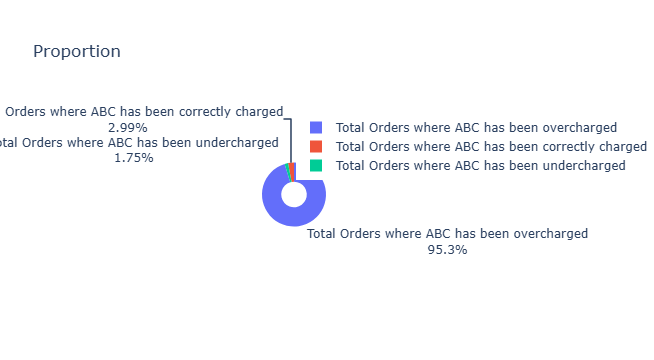

In [16]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Pie(labels=df_summary['Description'],
                            values=df_summary['Count'],
                            textinfo='label+percent',
                            hole=0.4))
fig.update_layout(title='Proportion')

fig.show()

B2B courier charges accuracy analysis focuses on assessing the accuracy of fees charged by courier companies for the delivery of goods in B2B transactions. In such problems, the aim was to ensure that companies are billed appropriately for the services provided by courier companies.